
# PFM: Evaluation Machine Learning Models

## **1. Importar librerías y datos**

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
# Librerias pickle y csv
import pickle
import csv

#importing models
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import neighbors
from sklearn import preprocessing, model_selection, metrics
from sklearn.preprocessing import StandardScaler

#import datetime
from datetime import date, datetime


In [2]:
#Cargamos los datasets y las definiciones de las variables para tenerlas a mano

def load_obj(name ):
       with open('obj/' + name + '.pkl', 'rb') as f:
           return pickle.load(f)

df_REE_04=load_obj('df_Tenerife_Electricity_2020_04_clean');
df_REE_07=load_obj('df_Tenerife_Electricity_2020_07_clean+EDA');
dict_REE=load_obj('dict_descripcion_df_Electricity');
df_Meteo_04=load_obj('df_Tenerife_Meteo_28.14_-16.46_2020_04_clean');
df_Meteo_07=load_obj('df_Tenerife_Meteo_28.14_-16.46_2020_07_clean');
dict_Meteo=load_obj('dict_descripcion_df_Meteo');

KNR_Model=load_obj('KNR_Model');
scalerX=load_obj('scalerX');
scalery=load_obj('scalery');

## **2. Combinar los datasets**

En este apartado se combinan los datasets eléctricos y meteo de manera que tengamos un único conjunto de datos, facilitando así la manipulación de estos y la construcción de los modelos. Este paso es importante para evitar errores y confusiones más adelante.


In [3]:
#Unimos los datasets  mediante .join()
#Esta función combina los datasets de acuerdo al índice del dataset principal (left)
df_REE_04['Aportacion_renovable_%']=df_REE_04['Generacion_renovable_MW']/df_REE_04['Demanda_real_MW']*100
df_REE_04['Month']=df_REE_04.index.month
df_REE_04['Hour']=df_REE_04.index.hour
df_REE_04['Season']=0

       
seasons = {3:(datetime(2019,6,21), datetime(2019,9,22)),
           1:(datetime(2019,9,23), datetime(2019,12,20)),
           2:(datetime(2019,3,21), datetime(2019,6,20))}

def get_season(date):
    for season,(season_start, season_end) in seasons.items():
        if date>=season_start and date<= season_end:
            return season
    else:
        return 0    
    
# Assuming df has a date column of type `datetime`
df_REE_04['Season'] = df_REE_04.index.map(get_season)

df_ML_04=df_REE_04.drop(['Generacion_CC_MW','Generacion_MD_MW','Generacion_TV_MW','Demanda_real_MW','Generacion_no_renovable_MW'],axis=1)

#df_ML_04=df_REE_04.join(df_Meteo_04)
#df_ML_04=df_ML_04.drop(['Generacion_CC_MW','Generacion_MD_MW','Generacion_TV_MW','Demanda_real_MW','Generacion_no_renovable_MW'],axis=1)
#df_ML_04

In [4]:
df_ML_04.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4320 entries, 2020-04-01 00:00:00 to 2020-04-30 23:50:00
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Generacion_renovable_MW  4320 non-null   float64
 1   Generacion_FV_MW         4320 non-null   float64
 2   Generacion_EO_MW         4320 non-null   float64
 3   Generacion_TG_MW         4320 non-null   float64
 4   Demanda_programada_MW    4320 non-null   float64
 5   Precio_generacion_€MWh   4320 non-null   float64
 6   Aportacion_renovable_%   4320 non-null   float64
 7   Month                    4320 non-null   int64  
 8   Hour                     4320 non-null   int64  
 9   Season                   4320 non-null   int64  
dtypes: float64(7), int64(3)
memory usage: 371.2 KB


In [5]:
#Unimos los datasets  mediante .join()
#Esta función combina los datasets de acuerdo al índice del dataset principal (left)
df_REE_07['Aportacion_renovable_%']=df_REE_07['Generacion_renovable_MW']/df_REE_07['Demanda_real_MW']*100
df_REE_07['Month']=df_REE_07.index.month
df_REE_07['Hour']=df_REE_07.index.hour
df_REE_07['Season']=0

       
seasons = {3:(datetime(2019,6,21), datetime(2019,9,22)),
           1:(datetime(2019,9,23), datetime(2019,12,20)),
           2:(datetime(2019,3,21), datetime(2019,6,20))}

def get_season(date):
    for season,(season_start, season_end) in seasons.items():
        if date>=season_start and date<= season_end:
            return season
    else:
        return 0    
    
# Assuming df has a date column of type `datetime`
df_REE_07['Season'] = df_REE_07.index.map(get_season)

df_ML_07=df_REE_07.drop(['Generacion_CC_MW','Generacion_MD_MW','Generacion_TV_MW','Demanda_real_MW','Generacion_no_renovable_MW'],axis=1)


#df_ML_07=df_REE_07.join(df_Meteo_07)
#df_ML_07=df_ML_07.drop(['Generacion_CC_MW','Generacion_MD_MW','Generacion_TV_MW','Demanda_real_MW','Generacion_no_renovable_MW'],axis=1)
#df_ML_07


In [6]:
df_ML_07.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4404 entries, 2020-07-01 00:00:00 to 2020-07-31 23:50:00
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Generacion_renovable_MW  4404 non-null   float64
 1   Generacion_FV_MW         4404 non-null   float64
 2   Generacion_EO_MW         4404 non-null   float64
 3   Generacion_TG_MW         4404 non-null   float64
 4   Demanda_programada_MW    4404 non-null   float64
 5   Precio_generacion_€MWh   4404 non-null   float64
 6   Aportacion_renovable_%   4404 non-null   float64
 7   Month                    4404 non-null   int64  
 8   Hour                     4404 non-null   int64  
 9   Season                   4404 non-null   int64  
dtypes: float64(7), int64(3)
memory usage: 378.5 KB


## **6. Other Regression Models**

En este apartado se van a probar otros modelos de regresión que suelen ser más efectivos en modelos no lineales de alta complejidad. 

Para realizar la comparación de estos modelos con el modelo base de regresión lineal, se va a utilizar el subset determinado en el stepwise backward elimination. Se descarta entrenar los algoritmos con el dataset origen para reducir el tiempo computacional y para que la comparación con el modelo base sea partiendo de la premisa que todos los modelos han sido entrenados con la misma cantidad de información. 

Si los resultados no son los esperados, siempre se puede manipular el dataset, añadir algunos datos o volver al dataset origen para entrenar de nuevo los modelos.

Probaremos los siguientes modelos:

    1.Support vector regression 

    2.KNeighborsRegressor

    3.Random Forest Regressor

    4.Gradient Boosting Regressor

    5.ExtraTrees Regressor

    6.Multi Layer Preceptron Regressor


### **6.1 Real Time Features**

In [7]:
# Podemos ver las features y la columna target
feature_vars = df_ML_04.drop(['Precio_generacion_€MWh'],axis=1)
target_vars = df_ML_04[['Precio_generacion_€MWh']]

#Variables de evaluacion 
X1 = df_ML_04[feature_vars.columns] 
y1 = df_ML_04[target_vars.columns] #['Precio_generacion_€MWh']
X2 = df_ML_07[feature_vars.columns]
y2 = df_ML_07[target_vars.columns]  #['Precio_generacion_€MWh']

El primer paso es la estandarización y normalización de las variables de evaluación. El modelo desarrollado trabaja con variables escaladas.

In [8]:
# Normalization of train and test data using mean and variance of the training:
X1 = scalerX.transform(X1)
y1 = scalery.transform(y1)
X2 = scalerX.transform(X2)
y2 = scalery.transform(y2)

In [9]:
df_evaluation = pd.DataFrame(columns=["Dataset", "Coef_R2", "RSME_€MWh", "MAE_€MWh"], index = range(2))

df_evaluation.iloc[0]=('Abril 20', KNR_Model.score(X1,y1), np.sqrt(mean_squared_error(scalery.inverse_transform(y1),scalery.inverse_transform(KNR_Model.predict(X1)))),metrics.mean_absolute_error(scalery.inverse_transform(y1),scalery.inverse_transform(KNR_Model.predict(X1))))
df_evaluation.iloc[1]=('Julio 20', KNR_Model.score(X2,y2), np.sqrt(mean_squared_error(scalery.inverse_transform(y2),scalery.inverse_transform(KNR_Model.predict(X2)))),metrics.mean_absolute_error(scalery.inverse_transform(y2),scalery.inverse_transform(KNR_Model.predict(X2))))

df_evaluation

,Dataset,Coef_R2,RSME_€MWh,MAE_€MWh
0,Abril 20,0.683882,12.785,8.77433
1,Julio 20,0.761873,9.19471,7.62478


In [10]:
y_KNR = scalery.inverse_transform(KNR_Model.predict(X1))
y_real = scalery.inverse_transform(y1)

df_Abril = df_ML_04.drop(['Generacion_renovable_MW','Generacion_FV_MW','Generacion_EO_MW','Generacion_TG_MW','Demanda_programada_MW','Aportacion_renovable_%','Month','Season'],axis=1)
df_Abril['y_KNR']=y_KNR
df_Abril['Day']=df_Abril.index.day
df_Abril_hourly=df_Abril.resample('H').mean()
df_Abril_daily=df_Abril.resample('D').mean()

df_Abril_daily

,Precio_generacion_€MWh,Hour,y_KNR,Day
time_series,,,,
2020-04-01,160.606667,11.5,156.242361,1.0
2020-04-02,153.499583,11.5,151.130077,2.0
2020-04-03,159.693333,11.5,147.073411,3.0
2020-04-04,165.836250,11.5,154.823987,4.0
2020-04-05,167.563750,11.5,154.680268,5.0
2020-04-06,159.965000,11.5,154.250214,6.0
2020-04-07,154.433750,11.5,151.869985,7.0
2020-04-08,153.852083,11.5,150.356644,8.0
2020-04-09,149.715833,11.5,147.093166,9.0


(100.0, 190.0)

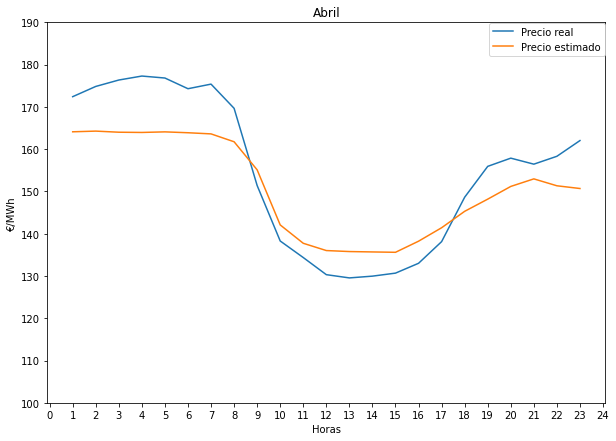

In [11]:
y_real = np.zeros((1,24))
y_KNR = np.zeros((1,24))
#m=0

plt.figure(figsize=(10,7))
 

for j in range (1,25,1):
    y_real[0,j-1]=df_Abril_hourly[df_Abril_hourly.index.hour == j]['Precio_generacion_€MWh'].mean()
    y_KNR[0,j-1]=df_Abril_hourly[df_Abril_hourly.index.hour == j]['y_KNR'].mean()
   
plt.plot(np.arange(1,25,1),y_real[0,:],label='Precio real')
plt.plot(np.arange(1,25,1),y_KNR[0,:],label='Precio estimado')
    
plt.legend(loc='best', borderaxespad=0.05)
plt.xlabel('Horas')
plt.ylabel('€/MWh')
plt.title('Abril')
plt.xticks(np.arange(0, 25, step=1))
plt.ylim(100,190)
    

(100.0, 190.0)

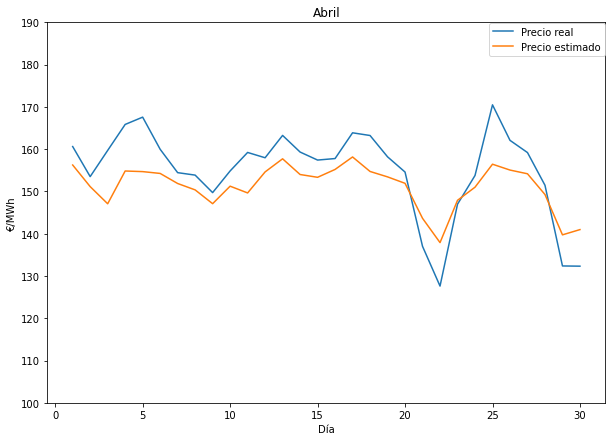

In [12]:
plt.figure(figsize=(10,7))

plt.plot(df_Abril_daily['Day'],df_Abril_daily['Precio_generacion_€MWh'],label='Precio real')
plt.plot(df_Abril_daily['Day'],df_Abril_daily['y_KNR'],label='Precio estimado')
    
plt.legend(loc='best', borderaxespad=0.05)
plt.xlabel('Día')
plt.ylabel('€/MWh')
plt.title('Abril')
#plt.xticks(np.arange(0, 25, step=1))
plt.ylim(100,190)


In [13]:
y_KNR = scalery.inverse_transform(KNR_Model.predict(X2))
y_real = scalery.inverse_transform(y2)

df_Julio = df_ML_07.drop(['Generacion_renovable_MW','Generacion_FV_MW','Generacion_EO_MW','Generacion_TG_MW','Demanda_programada_MW','Aportacion_renovable_%','Month','Season'],axis=1)
df_Julio['y_KNR']=y_KNR
df_Julio['Day']=df_Julio.index.day
df_Julio_hourly=df_Julio.resample('H').mean()
df_Julio_daily=df_Julio.resample('D').mean()

df_Julio_daily

,Precio_generacion_€MWh,Hour,y_KNR,Day
time_series,,,,
2020-07-01,137.172500,11.500000,141.568699,1.0
2020-07-02,123.294167,11.500000,133.207466,2.0
2020-07-03,117.086250,11.500000,130.019237,3.0
2020-07-04,133.867083,11.500000,142.415800,4.0
2020-07-05,150.392500,11.500000,151.466607,5.0
2020-07-06,149.222083,11.500000,153.691775,6.0
2020-07-07,159.882083,11.500000,162.781920,7.0
2020-07-08,142.873333,11.500000,146.346816,8.0
2020-07-09,123.617083,11.500000,133.050601,9.0


(100.0, 190.0)

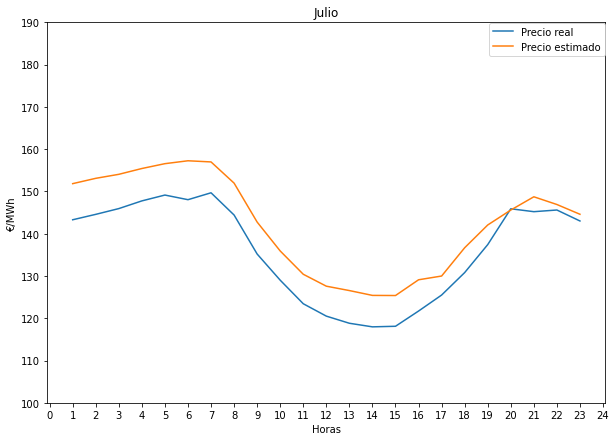

In [14]:
y_real = np.zeros((1,24))
y_KNR = np.zeros((1,24))
#m=0

plt.figure(figsize=(10,7))
 

for j in range (1,25,1):
    y_real[0,j-1]=df_Julio_hourly[df_Julio_hourly.index.hour == j]['Precio_generacion_€MWh'].mean()
    y_KNR[0,j-1]=df_Julio_hourly[df_Julio_hourly.index.hour == j]['y_KNR'].mean()
   
plt.plot(np.arange(1,25,1),y_real[0,:],label='Precio real')
plt.plot(np.arange(1,25,1),y_KNR[0,:],label='Precio estimado')
    
plt.legend(loc='best', borderaxespad=0.05)
plt.xlabel('Horas')
plt.ylabel('€/MWh')
plt.title('Julio')
plt.xticks(np.arange(0, 25, step=1))
plt.ylim(100,190)
    

(100.0, 190.0)

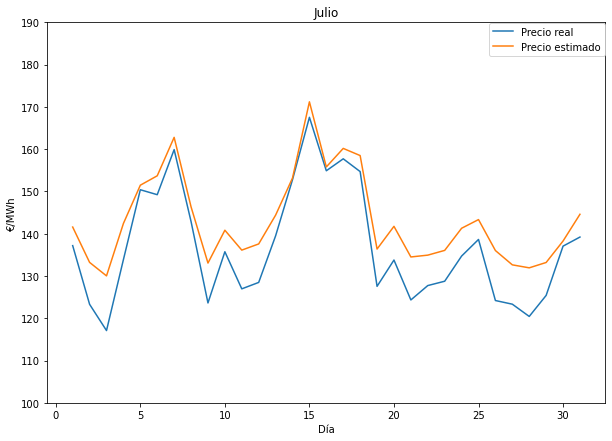

In [15]:
plt.figure(figsize=(10,7))

plt.plot(df_Julio_daily['Day'],df_Julio_daily['Precio_generacion_€MWh'],label='Precio real')
plt.plot(df_Julio_daily['Day'],df_Julio_daily['y_KNR'],label='Precio estimado')
    
plt.legend(loc='best', borderaxespad=0.05)
plt.xlabel('Día')
plt.ylabel('€/MWh')
plt.title('Julio')
#plt.xticks(np.arange(0, 25, step=1))
plt.ylim(100,190)

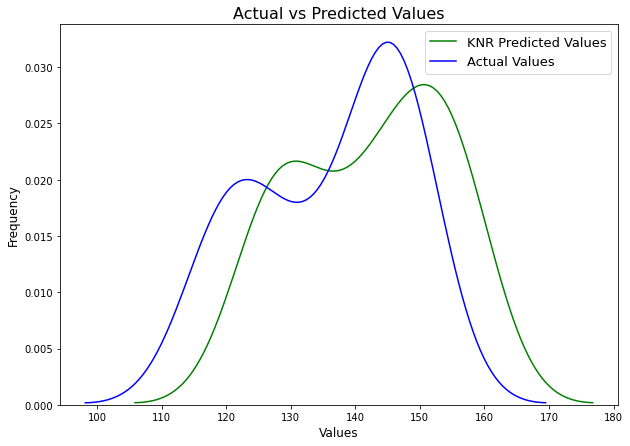

In [16]:
#Graficamos los valores predichos VS los valores reales
plt.figure(figsize=(10,7))
sns.distplot(y_KNR, hist = False, color = 'g', label = 'KNR Predicted Values')
sns.distplot(y_real, hist = False, color = 'b', label = 'Actual Values')

plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'best', fontsize = 13)

#plt.savefig('fig/' + 'Predicted_VS_Actual_MLR.png', dpi=200)

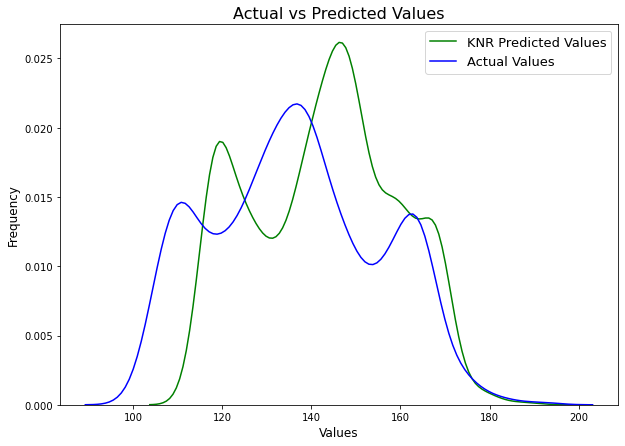

In [17]:
y_KNR = scalery.inverse_transform(KNR_Model.predict(X2))
y_real = scalery.inverse_transform(y2)

#Graficamos los valores predichos VS los valores reales
plt.figure(figsize=(10,7))
sns.distplot(y_KNR, hist = False, color = 'g', label = 'KNR Predicted Values')
sns.distplot(y_real, hist = False, color = 'b', label = 'Actual Values')

plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'best', fontsize = 13)

#plt.savefig('fig/' + 'Predicted_VS_Actual_MLR.png', dpi=200)